In [ ]:
import os
import numpy as np
import pandas as pd
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
rng = np.random.default_rng(0)
az.style.use("arviz-darkgrid")
%matplotlib inline

### 1. Get SP500 data

In [ ]:
# !pip install pandas_datareader

In [ ]:
import pandas_datareader.data as web
import datetime

In [ ]:
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()

sp500 = web.DataReader(['sp500'], 'fred', start, end)

In [ ]:
sp500.shape

(2609, 1)

In [ ]:
sp500.head()

,sp500,change
DATE,,
2012-02-10,1342.64,-0.006910
2012-02-13,1351.77,0.006777
2012-02-14,1350.50,-0.000940
2012-02-15,1343.23,-0.005398
2012-02-16,1358.04,0.010965


In [ ]:
sp500["change"] = np.log(sp500["sp500"]).diff()

In [ ]:
sp500.isna().sum()

sp500     0
change    1
dtype: int64

In [ ]:
sp500 = sp500.dropna()

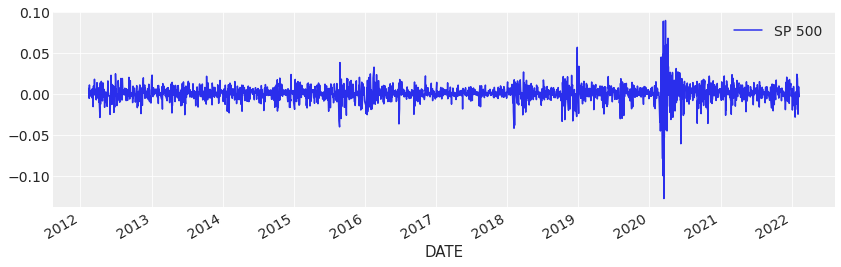

In [ ]:
# Plot data
fig, ax = plt.subplots(figsize=(14,4))
sp500.plot(y="change", label="SP 500", ax=ax);

### Model

In [ ]:
def make_sv_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, dims="time")
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT("returns", nu=nu, lam=np.exp(-2*volatility), observed=data["change"])
    return model

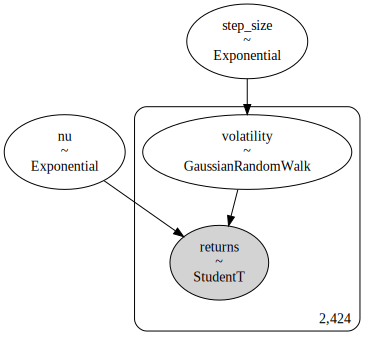

In [ ]:
model = make_sv_model(sp500)
pm.model_to_graphviz(model)

In [ ]:
with model:
    trace = az.from_pymc3(prior=pm.sample_prior_predictive(1000))

In [ ]:
prior_predictive = trace.prior_predictive.stack(pooled_chain=("chain", "draw"))

In [ ]:
prior_predictive

<xarray.Dataset>
Dimensions:        (pooled_chain: 1000, returns_dim_0: 2424)
Coordinates:
  * returns_dim_0  (returns_dim_0) int64 0 1 2 3 4 ... 2419 2420 2421 2422 2423
  * pooled_chain   (pooled_chain) MultiIndex
  - chain          (pooled_chain) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  - draw           (pooled_chain) int64 0 1 2 3 4 5 ... 994 995 996 997 998 999
Data variables:
    returns        (returns_dim_0, pooled_chain) float64 0.978 -5.39 ... -0.9386
Attributes:
    created_at:                 2022-02-09T10:47:05.609321
    arviz_version:              0.8.3
    inference_library:          pymc3
    inference_library_version:  3.9.0

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
sp500["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"].isel(pooled_chain=slice(4, 6, None)),
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

NameError: name 'returns' is not defined

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f58f561fc20> (for post_execute):


ValueError: view limit minimum -36909.700000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36909.700000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

### Fit Model

In [ ]:
with model:
    trace = pm.sample(2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, volatility, step_size]


In [ ]:
ppc = trace.posterior.stack(pooled_chain=("chain", "draw"))
ppc["exp_volatility"] = np.exp(posterior["volatility"]

In [ ]:
with mode